In [1]:
train_and_save = True

# Import

### Librerie

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Sequential, Model
from keras.layers import *
from sklearn.metrics import *
from keras.optimizers import Adam
from statsmodels.tsa.seasonal import seasonal_decompose
import keras.backend as K
from tensorflow import keras
from tensorflow.keras import layers
import time
from math import sqrt
import json
from efficientnet.tfkeras import EfficientNetB4

### Dataset

In [3]:
dataset = pd.read_csv('./dataset.csv')

In [4]:
dataset[160:180]

,user_id,date,steps,bedin,bedout,sleep duration,deepduration,lightduration
160,2bc16eda651db5936cd31e735c815296fc1579d9,2017-02-10,5305.23,25.26,6.33,4.60,1.72,2.88
161,2bc16eda651db5936cd31e735c815296fc1579d9,2017-02-11,7534.40,23.03,7.69,8.53,4.22,4.34
162,2bc16eda651db5936cd31e735c815296fc1579d9,2017-03-08,4560.29,23.53,6.28,6.51,2.08,4.44
163,2bc16eda651db5936cd31e735c815296fc1579d9,2017-03-09,6990.77,23.16,6.44,7.07,2.84,4.24
164,2bc16eda651db5936cd31e735c815296fc1579d9,2017-03-10,8324.80,23.42,5.90,6.35,2.26,4.11
165,2bc16eda651db5936cd31e735c815296fc1579d9,2017-03-11,6052.50,23.17,6.18,6.73,2.86,3.90
166,2bc16eda651db5936cd31e735c815296fc1579d9,2017-03-12,7725.14,21.67,6.95,8.72,3.79,4.98
167,2bc16eda651db5936cd31e735c815296fc1579d9,2017-03-13,10042.03,21.28,5.59,8.08,2.37,5.71
168,2bc16eda651db5936cd31e735c815296fc1579d9,2017-03-14,7957.16,25.40,7.71,6.16,2.24,3.91
169,ce96039ca66a9b98f97b202c177cf0ef7d4aa97d,2016-04-19,6689.42,23.37,6.47,6.53,1.18,3.83


In [5]:
# creo una lista di dataframe dove ogni elemento è l'insieme delle date per utente
utenti = []
# carico elenco utenti per scorrere tutti gli id
elenco_utenti = pd.read_csv('./userinfo.csv', usecols=['user_id', 'timezone', 'sex', 'age', 'height'])
elenco_utenti.head()

,user_id,timezone,sex,age,height
0,d9874c86e6db7bf4c3959445b0b05a1bb8e60bbf,UTC,Male,27,184
1,fe5d7aacd82682e68d94ea1e6aa33a1e858337f7,PDT,Female,39,175
2,88359b8e24f4d6b758fb4566860ba9842fc5b350,UTC,Male,26,179
3,e061ccf5eece921027f618686a5aa2412d753b6b,PDT,Female,27,169
4,2e88aac4e69049d0845a5e2dce661ae8f4f55239,UTC,Male,61,177


In [6]:
dataset.set_index(['user_id','date'], inplace=True)

In [7]:
# inserisco per ogni elemento della lista il dataframe relativo ad un utente presente nel dataset
for index, series in elenco_utenti.iterrows():
    utente = series['user_id']
    if utente in dataset.index:
        utenti.append(dataset.loc[utente])
len(utenti)

7986

In [13]:
"""
# elimina stagionalità
senza_stag = []
#stato = 0
for corrente in utenti:
    #print(str(stato) + " / 7984 ")
    #stato = stato+1;
    if len(corrente) >=14:
        lista_stag = []
        lista_stag.append(corrente[['steps']].squeeze() - seasonal_decompose(corrente[['steps']], model='additive', period = 7).seasonal)
        lista_stag.append(corrente[['bedin']].squeeze() - seasonal_decompose(corrente[['bedin']], model='additive', period = 7).seasonal)
        lista_stag.append(corrente[['bedout']].squeeze() - seasonal_decompose(corrente[['bedout']], model='additive', period = 7).seasonal)
        lista_stag.append(corrente[['sleep duration']].squeeze() - seasonal_decompose(corrente[['sleep duration']], model='additive', period = 7).seasonal)
        lista_stag.append(corrente[['deepduration']].squeeze()  - seasonal_decompose(corrente[['deepduration']], model='additive', period = 7).seasonal)
        lista_stag.append(corrente[['lightduration']].squeeze() - seasonal_decompose(corrente[['lightduration']], model='additive', period = 7).seasonal)
        frame = {'steps' : lista_stag[0], 'bedin' : lista_stag[1], 'bedout' : lista_stag[2], 'sleep duration' : lista_stag[3], 'deepduration' : lista_stag[4], 'lightduration' : lista_stag[5]}
        senza_stag.append(pd.DataFrame(frame))
utenti = senza_stag
"""

In [17]:
"""
# Funzione normalizzazione
scaler = MinMaxScaler(feature_range=(0,1))
def normalizza(dat):
    df_for_training_scaled = scaler.fit_transform(dat)
    return df_for_training_scaled
"""

In [18]:
"""
# Adesso normalizza ogni dataset
utenti_normalizzati = []
for u in utenti:
    utenti_normalizzati.append(normalizza(u))
"""

In [8]:
# window_size is the number of step we will look in the past to predict the next target value.
# 0:steps, 1:bedin, 2:bedout, 3:sleep duration, 4:deep duration, 5:lightduration
col2pred = 4
window_size = 7
def createXY(dataset_parameter, window_size):
    dataX = []
    dataY = []
    for i in range(window_size, len(dataset_parameter)):
        #per ogni feature fa l'append dei precedenti
        dataX.append(dataset_parameter[i - window_size:i, 0:dataset_parameter.shape[1]])
        dataY.append(dataset_parameter[i, col2pred])
    return np.array(dataX), np.array(dataY)

In [22]:
n_utenti_train = (len(utenti) * 80) // 100

In [23]:
# crea insieme di train
train_lista = utenti[:n_utenti_train]

trainX_lista = []
trainY_lista = []

for t in train_lista:
    trainX_temp, trainY_temp = createXY(t.to_numpy() ,window_size)
    if len(trainX_temp.shape) == 3 and len(trainY_temp.shape) == 1:
        trainX_lista.append(trainX_temp)
        trainY_lista.append(trainY_temp)

trainX = np.concatenate(trainX_lista)
trainY = np.concatenate(trainY_lista)

In [25]:
# crea insieme di test
test_lista = utenti[n_utenti_train:]

testX_lista = []
testY_lista = []

for t in test_lista:
    testX_temp, testY_temp = createXY(t.to_numpy(),window_size)
    if len(testX_temp.shape) == 3 and len(testY_temp.shape) == 1:
        testX_lista.append(testX_temp)
        testY_lista.append(testY_temp)

testX = np.concatenate(testX_lista)
testY = np.concatenate(testY_lista)

In [29]:
print(trainX.shape, testX.shape, trainY.shape, testY.shape)

print(trainX[0:10])
print('---')
print(trainY[0:10])

(736860, 7, 6) (186561, 7, 6) (736860,) (186561,)
[[[1.632270e+03 3.173000e+01 1.443000e+01 6.720000e+00 4.200000e+00
   2.520000e+00]
  [5.364540e+03 2.942000e+01 1.245000e+01 7.000000e+00 2.570000e+00
   4.470000e+00]
  [2.000199e+04 2.599000e+01 6.610000e+00 4.700000e+00 2.970000e+00
   1.740000e+00]
  [2.117990e+04 2.594000e+01 1.285000e+01 1.099000e+01 5.620000e+00
   5.330000e+00]
  [2.303536e+04 2.656000e+01 8.840000e+00 5.920000e+00 3.890000e+00
   2.040000e+00]
  [1.645067e+04 2.819000e+01 1.272000e+01 7.830000e+00 2.490000e+00
   5.350000e+00]
  [2.514165e+04 2.969000e+01 8.840000e+00 3.060000e+00 1.970000e+00
   1.100000e+00]]

 [[5.364540e+03 2.942000e+01 1.245000e+01 7.000000e+00 2.570000e+00
   4.470000e+00]
  [2.000199e+04 2.599000e+01 6.610000e+00 4.700000e+00 2.970000e+00
   1.740000e+00]
  [2.117990e+04 2.594000e+01 1.285000e+01 1.099000e+01 5.620000e+00
   5.330000e+00]
  [2.303536e+04 2.656000e+01 8.840000e+00 5.920000e+00 3.890000e+00
   2.040000e+00]
  [1.645067e+

In [14]:
# features num
features_num = dataset.shape[1]
features_num

6

# Metriche

In [15]:
def metrics(model, trainX, trainY, testX, testY, history):
    
    # stampa metriche
    score_train = model.evaluate(trainX, trainY, verbose = 0)
    print("**********TRAIN-SET***********")
    print("MSE: {}".format(score_train[1]))
    print("RMSE: {}".format(sqrt(score_train[1])))
    print("MAE: {}".format(score_train[2]))
    
    score_test = model.evaluate(testX, testY, verbose = 0)
    print("**********TEST-SET***********")
    print("MSE: {}".format(score_test[1]))
    print("RMSE: {}".format(sqrt(score_test[1])))
    print("MAE: {}".format(score_test[2]))

    #plot predizioni
    prediction_test=model.predict(testX, verbose = 0)
    prediction_copies_test_array = np.repeat(prediction_test,features_num, axis=-1)
    pred_test=np.reshape(prediction_copies_test_array,(len(prediction_test),features_num))[:,col2pred]
    true_value_test_copies_array = np.repeat(testY,features_num, axis=-1)
    true_value_test=np.reshape(true_value_test_copies_array,(len(testY),features_num))[:,col2pred]
    
    plt.plot(true_value_test[:150], color='red', label='Real deep duration')
    plt.plot(pred_test[:150], color='blue', label='Predicted deep duration')
    plt.title('Deep duration Prediction')
    plt.xlabel('Time')
    plt.ylabel('Deep duration')
    plt.legend()
    plt.show()
    
    # plot andamento loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss (mse)')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    
    # plot andamento loss
    plt.plot(history['mae'])
    plt.plot(history['val_mae'])
    plt.title('model mae')
    plt.ylabel('mae')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

# Data manipulation 

In [16]:
def values4metrics(model, trainX, trainY, testX, testY):
    prediction_train = model.predict(trainX)
    prediction_train_copies_array = np.repeat(prediction_train, features_num, axis=-1)
    pred_train = np.reshape(prediction_train_copies_array, (len(prediction_train), features_num))[:, col2pred]
    true_value_train_copies_array = np.repeat(trainY, features_num, axis=-1)
    true_value_train = np.reshape(true_value_train_copies_array, (len(trainY), features_num))[:, col2pred]

    prediction_test=model.predict(testX)
    prediction_copies_test_array = np.repeat(prediction_test,features_num, axis=-1)
    pred_test=np.reshape(prediction_copies_test_array,(len(prediction_test),features_num))[:,col2pred]
    true_value_test_copies_array = np.repeat(testY,features_num, axis=-1)
    true_value_test=np.reshape(true_value_test_copies_array,(len(testY),features_num))[:,col2pred]
    
    return true_value_train, pred_train, true_value_test, pred_test

# Architetture di supporto

In [17]:
class Time2Vec(Layer):

    def __init__(self, output_dimension=None, **kwargs):
        self.output_dimension = output_dimension
        super(Time2Vec, self).__init__(**kwargs)

    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dimension": self.output_dimension,
        })
        return config

    def build(self, input_shape):

        self.W = self.add_weight(name='W',
                                shape=(input_shape[-1], self.output_dimension),
                                initializer='uniform',
                                trainable=True)

        self.P = self.add_weight(name='P',
                                shape=(input_shape[1], self.output_dimension),
                                initializer='uniform',
                                trainable=True)

        self.w = self.add_weight(name='w',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        self.p = self.add_weight(name='p',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        super(Time2Vec, self).build(input_shape)

    def call(self, x):

        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)

        return K.concatenate([sin_trans, original], -1)

In [18]:
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = keras.Input(shape=input_shape)
    time_embedding = Time2Vec(120)(inputs)
    #x = inputs
    x = time_embedding
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="tanh")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(1)(x)
    return keras.Model(inputs, outputs)

input_shape = trainX.shape[1:]

model_transformer = build_model(input_shape, head_size=256, num_heads=2, ff_dim=4, num_transformer_blocks=2, mlp_units=[64], mlp_dropout=0.5, dropout=0.25)

model_transformer.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['mse', 'mae'])

RuntimeError: Exception encountered when calling Time2Vec.call().

[1mCould not automatically infer the output shape / dtype of 'time2_vec' (of type Time2Vec). Either the `Time2Vec.call()` method is incorrect, or you need to implement the `Time2Vec.compute_output_spec() / compute_output_shape()` method. Error encountered:

module 'keras.backend' has no attribute 'sin'[0m

Arguments received by Time2Vec.call():
  • args=('<KerasTensor shape=(None, 7, 6), dtype=float32, sparse=None, name=keras_tensor>',)
  • kwargs=<class 'inspect._empty'>

In [19]:
model_transformer.summary()

NameError: name 'model_transformer' is not defined

# Funzione per richiamare i modelli

In [33]:
def model_recurrent(type = 'gru'):
    model = Sequential()
    
    if type == 'gru': # GRU
        model.add(GRU(256, return_sequences=True, input_shape=(window_size, features_num)))
        model.add(GRU(128, return_sequences=True))
        model.add(GRU(64))
        model.add(Dropout(0.25))
        model.add(Dense(32, activation='tanh'))
        model.add(Dropout(0.5))
        
    if type == 'lstm': # LSTM
        model.add(LSTM(256, return_sequences=True,input_shape=(window_size, features_num)))
        model.add(LSTM(128, return_sequences=True))
        model.add(LSTM(64))
        model.add(Dropout(0.25))
        model.add(Dense(32, activation='tanh'))
        model.add(Dropout(0.5))
    
    if type == 'bidirectional':  # Bidirectional
        model.add(Bidirectional(LSTM(256, return_sequences=True), input_shape=(window_size,features_num)))
        model.add(Bidirectional(LSTM(128, return_sequences=True)))
        model.add(Bidirectional(LSTM(64)))
        model.add(Dropout(0.25))
        model.add(Dense(32, activation='tanh'))
        model.add(Dropout(0.5))   

    if type == 'time2vec':  # Time2Vec
        model.add(Input(shape=(window_size, features_num)))
        model.add(Time2Vec(120))
        model.add(LSTM(128, return_sequences=True))
        model.add(LSTM(64))
        model.add(Dropout(0.25))
        model.add(Dense(32, activation='tanh'))
        model.add(Dropout(0.5))  
        
    if type == 'cnn':  # CNN
        model.add(Conv1D(filters=128, kernel_size=2, activation='tanh', input_shape=(window_size,features_num)))
        model.add(Conv1D(filters=64, kernel_size=2, activation='tanh'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Flatten())
        model.add(RepeatVector(features_num))
        model.add(LSTM(units=100, return_sequences=True))
        model.add(Dropout(0.2))
        model.add(LSTM(units=100))
        model.add(Dense(100, activation='tanh'))        

    model.add(Dense(1))
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.001), metrics=['mse', 'mae'])
    return model 

# Iperparametri

In [45]:
n_epoche = 50
batch = 4096 # 8192 - 4096

# GRU

In [50]:
model_gru = model_recurrent('gru')
model_gru.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 7, 256)            202752    
                                                                 
 gru_7 (GRU)                 (None, 7, 128)            148224    
                                                                 
 gru_8 (GRU)                 (None, 64)                37248     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dropout_10 (Dropout)        (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                

In [51]:
if train_and_save == True:
    start = time.time()
    history_gru = model_gru.fit(trainX, trainY, epochs = n_epoche, verbose = 1, batch_size = batch, validation_split = 0.2) # 8192
    end = time.time()
    time_gru = end-start
    model_gru.save('./trained_model/DeepDuration/model_gru_e' + str(n_epoche) + "_b" + str(batch) + '.h5')
else:
    model_gru = keras.models.load_model('./trained_model/DeepDuration/model_gru_e' + str(n_epoche) + "_b" + str(batch) + '.h5') 

Epoch 1/50
161/161 [==============================] - 154s 927ms/step - loss: 0.0468 - mse: 0.0468 - mae: 0.1694 - val_loss: 0.0325 - val_mse: 0.0325 - val_mae: 0.1414
Epoch 2/50
161/161 [==============================] - 151s 940ms/step - loss: 0.0386 - mse: 0.0386 - mae: 0.1545 - val_loss: 0.0325 - val_mse: 0.0325 - val_mae: 0.1408
Epoch 3/50
161/161 [==============================] - 153s 951ms/step - loss: 0.0369 - mse: 0.0369 - mae: 0.1509 - val_loss: 0.0325 - val_mse: 0.0325 - val_mae: 0.1406
Epoch 4/50
161/161 [==============================] - 153s 952ms/step - loss: 0.0357 - mse: 0.0357 - mae: 0.1482 - val_loss: 0.0322 - val_mse: 0.0322 - val_mae: 0.1403
Epoch 5/50
161/161 [==============================] - 151s 940ms/step - loss: 0.0349 - mse: 0.0349 - mae: 0.1466 - val_loss: 0.0322 - val_mse: 0.0322 - val_mae: 0.1404
Epoch 6/50
161/161 [==============================] - 134s 832ms/step - loss: 0.0343 - mse: 0.0343 - mae: 0.1451 - val_loss: 0.0321 - val_mse: 0.0321 - val_mae:

c:\Users\ivanc\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# LSTM

In [52]:
model_lstm = model_recurrent('lstm')
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 256)            269312    
                                                                 
 lstm_1 (LSTM)               (None, 7, 128)            197120    
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_11 (Dropout)        (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dropout_12 (Dropout)        (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                

In [59]:
from tensorflow import config
config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [53]:
if train_and_save == True:
    start = time.time()
    history_lstm = model_lstm.fit(trainX, trainY, epochs = n_epoche, verbose = 1, batch_size = batch, validation_split = 0.2) # 8192
    end = time.time()
    time_lstm = end-start
    model_lstm.save('./trained_model/model_lstm_e' + str(n_epoche) + "_b" + str(batch) + '.h5')
else:
    model_lstm = keras.models.load_model('./trained_model/model_lstm_e' + str(n_epoche) + "_b" + str(batch) + '.h5') 

Epoch 1/50
 81/161 [==============>...............] - ETA: 1:17 - loss: 0.0517 - mse: 0.0517 - mae: 0.1786

KeyboardInterrupt: 

# Bidirectional - LSTM

In [27]:
model_bi = model_recurrent('bidirectional')
model_bi.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 7, 512)           538624    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 7, 256)           656384    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 32)                4128      
                                                      

In [28]:
if train_and_save == True:
    start = time.time()
    history_bi = model_bi.fit(trainX, trainY, epochs = n_epoche, verbose = 1, batch_size = batch, validation_split = 0.2) # 8192
    end = time.time()
    time_bi = end-start
    model_bi.save('./trained_model/model_bidirectional_e' + str(n_epoche) + "_b" + str(batch) + '.h5')
else:
    model_bi = keras.models.load_model('./trained_model/model_bidirectional_e' + str(n_epoche) + "_b" + str(batch) + '.h5') 

Epoch 1/50
161/161 [==============================] - 21s 75ms/step - loss: 0.0449 - mse: 0.0449 - mae: 0.1660 - val_loss: 0.0323 - val_mse: 0.0323 - val_mae: 0.1407
Epoch 2/50
161/161 [==============================] - 10s 63ms/step - loss: 0.0383 - mse: 0.0383 - mae: 0.1538 - val_loss: 0.0324 - val_mse: 0.0324 - val_mae: 0.1405
Epoch 3/50
161/161 [==============================] - 10s 63ms/step - loss: 0.0369 - mse: 0.0369 - mae: 0.1507 - val_loss: 0.0322 - val_mse: 0.0322 - val_mae: 0.1399
Epoch 4/50
161/161 [==============================] - 10s 63ms/step - loss: 0.0357 - mse: 0.0357 - mae: 0.1481 - val_loss: 0.0322 - val_mse: 0.0322 - val_mae: 0.1405
Epoch 5/50
161/161 [==============================] - 10s 63ms/step - loss: 0.0349 - mse: 0.0349 - mae: 0.1464 - val_loss: 0.0321 - val_mse: 0.0321 - val_mae: 0.1398
Epoch 6/50
161/161 [==============================] - 10s 63ms/step - loss: 0.0342 - mse: 0.0342 - mae: 0.1449 - val_loss: 0.0322 - val_mse: 0.0322 - val_mae: 0.1400
Epoc

# Time2Vec - LSTM

In [29]:
model_t2v = model_recurrent('time2vec')
model_t2v.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time2_vec (Time2Vec)        (None, 7, 126)            1574      
                                                                 
 lstm_6 (LSTM)               (None, 7, 128)            130560    
                                                                 
 lstm_7 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dropout_16 (Dropout)        (None, 32)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                

In [30]:
if train_and_save == True:
    start = time.time()
    history_t2v = model_t2v.fit(trainX, trainY, epochs = n_epoche, verbose = 1, batch_size = batch, validation_split = 0.2) # 8192
    end = time.time()
    time_t2v = end-start
    model_t2v.save('./trained_model/model_time2vec_e' + str(n_epoche) + "_b" + str(batch) + '.h5')
else:
    model_t2v = keras.models.load_model('./trained_model/model_time2vec_e' + str(n_epoche) + "_b" + str(batch) + '.h5', custom_objects={'Time2Vec': Time2Vec})

Epoch 1/50
161/161 [==============================] - 7s 21ms/step - loss: 0.0475 - mse: 0.0475 - mae: 0.1709 - val_loss: 0.0326 - val_mse: 0.0326 - val_mae: 0.1412
Epoch 2/50
161/161 [==============================] - 2s 15ms/step - loss: 0.0386 - mse: 0.0386 - mae: 0.1545 - val_loss: 0.0327 - val_mse: 0.0327 - val_mae: 0.1410
Epoch 3/50
161/161 [==============================] - 2s 15ms/step - loss: 0.0372 - mse: 0.0372 - mae: 0.1514 - val_loss: 0.0323 - val_mse: 0.0323 - val_mae: 0.1408
Epoch 4/50
161/161 [==============================] - 2s 15ms/step - loss: 0.0361 - mse: 0.0361 - mae: 0.1490 - val_loss: 0.0325 - val_mse: 0.0325 - val_mae: 0.1406
Epoch 5/50
161/161 [==============================] - 2s 15ms/step - loss: 0.0352 - mse: 0.0352 - mae: 0.1471 - val_loss: 0.0322 - val_mse: 0.0322 - val_mae: 0.1402
Epoch 6/50
161/161 [==============================] - 2s 15ms/step - loss: 0.0345 - mse: 0.0345 - mae: 0.1456 - val_loss: 0.0322 - val_mse: 0.0322 - val_mae: 0.1399
Epoch 7/50

# CNN - LSTM

In [31]:
model_cnn = model_recurrent('cnn')
model_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 6, 128)            1664      
                                                                 
 conv1d_9 (Conv1D)           (None, 5, 64)             16448     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 64)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 6, 128)           0         
 )                                                               
                                                                 
 lstm_8 (LSTM)               (None, 6, 100)           

In [32]:
if train_and_save == True:
    start = time.time()
    history_cnn = model_cnn.fit(trainX, trainY, epochs = n_epoche, verbose = 1, batch_size = batch, validation_split = 0.2) # 8192
    end = time.time()
    time_cnn = end-start
    model_cnn.save('./trained_model/model_cnn_e' + str(n_epoche) + "_b" + str(batch) + '.h5')
else:
    model_cnn = keras.models.load_model('./trained_model/model_cnn_e' + str(n_epoche) + "_b" + str(batch) + '.h5')

Epoch 1/50
161/161 [==============================] - 8s 27ms/step - loss: 0.0366 - mse: 0.0366 - mae: 0.1499 - val_loss: 0.0329 - val_mse: 0.0329 - val_mae: 0.1427
Epoch 2/50
161/161 [==============================] - 3s 19ms/step - loss: 0.0333 - mse: 0.0333 - mae: 0.1432 - val_loss: 0.0329 - val_mse: 0.0329 - val_mae: 0.1423
Epoch 3/50
161/161 [==============================] - 3s 20ms/step - loss: 0.0332 - mse: 0.0332 - mae: 0.1430 - val_loss: 0.0342 - val_mse: 0.0342 - val_mae: 0.1459
Epoch 4/50
161/161 [==============================] - 3s 19ms/step - loss: 0.0332 - mse: 0.0332 - mae: 0.1429 - val_loss: 0.0328 - val_mse: 0.0328 - val_mae: 0.1411
Epoch 5/50
161/161 [==============================] - 3s 19ms/step - loss: 0.0332 - mse: 0.0332 - mae: 0.1428 - val_loss: 0.0333 - val_mse: 0.0333 - val_mae: 0.1435
Epoch 6/50
161/161 [==============================] - 3s 19ms/step - loss: 0.0332 - mse: 0.0332 - mae: 0.1428 - val_loss: 0.0326 - val_mse: 0.0326 - val_mae: 0.1407
Epoch 7/50

# T2V - Transformer 

In [62]:
model_transformer.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 7, 6)]       0           []                               
                                                                                                  
 time2_vec_11 (Time2Vec)        (None, 7, 126)       1574        ['input_12[0][0]']               
                                                                                                  
 layer_normalization_74 (LayerN  (None, 7, 126)      252         ['time2_vec_11[0][0]']           
 ormalization)                                                                                    
                                                                                                  
 multi_head_attention_37 (Multi  (None, 7, 126)      259710      ['layer_normalization_74[0

In [63]:
if train_and_save == True:
    start = time.time()
    history_t= model_transformer.fit(trainX, trainY, epochs = n_epoche, verbose = 1, batch_size = batch, validation_split = 0.2) # 8192
    end = time.time()
    time_t = end-start
    model_transformer.save('./trained_model/model_transformer_e' + str(n_epoche) + "_b" + str(batch) + '.h5')
else:
    model_transformer = keras.models.load_model('./trained_model/model_transformer_e' + str(n_epoche) + "_b" + str(batch) + '.h5', custom_objects={'Time2Vec': Time2Vec})

Epoch 1/50
161/161 [==============================] - 16s 81ms/step - loss: 0.0456 - mse: 0.0456 - mae: 0.1654 - val_loss: 0.0324 - val_mse: 0.0324 - val_mae: 0.1401
Epoch 2/50
161/161 [==============================] - 13s 78ms/step - loss: 0.0361 - mse: 0.0361 - mae: 0.1493 - val_loss: 0.0321 - val_mse: 0.0321 - val_mae: 0.1402
Epoch 3/50
161/161 [==============================] - 12s 75ms/step - loss: 0.0356 - mse: 0.0356 - mae: 0.1481 - val_loss: 0.0329 - val_mse: 0.0329 - val_mae: 0.1430
Epoch 4/50
161/161 [==============================] - 12s 77ms/step - loss: 0.0351 - mse: 0.0351 - mae: 0.1471 - val_loss: 0.0329 - val_mse: 0.0329 - val_mae: 0.1427
Epoch 5/50
161/161 [==============================] - 12s 74ms/step - loss: 0.0348 - mse: 0.0348 - mae: 0.1463 - val_loss: 0.0320 - val_mse: 0.0320 - val_mae: 0.1401
Epoch 6/50
161/161 [==============================] - 12s 75ms/step - loss: 0.0344 - mse: 0.0344 - mae: 0.1455 - val_loss: 0.0319 - val_mse: 0.0319 - val_mae: 0.1396
Epoc

161/161 [==============================] - 12s 75ms/step - loss: 0.0324 - mse: 0.0324 - mae: 0.1409 - val_loss: 0.0321 - val_mse: 0.0321 - val_mae: 0.1404


In [64]:
print(time_t) 

604.433164358139


##### Salva i tempi di allenamento

In [69]:
if train_and_save == True:
    dictionary = {
        "gru": time_gru,
        "lstm": time_lstm,
        "bidirectional": time_bi,
        "time2vec": time_t2v,
        "cnn": time_cnn,
        "transformer": time_t
    }

    with open("./trained_model/training_times.json", "w") as outfile:
        json.dump(dictionary, outfile)
        
        
        
with open("./trained_model/training_times.json", 'r') as openfile:
    dict_times = json.load(openfile)

In [36]:
if train_and_save == True:
    dictionary = {
        "gru": history_gru.history,
        "lstm": history_lstm.history,
        "bidirectional": history_bi.history,
        "time2vec": history_t2v.history,
        "cnn": history_cnn.history,
        "transformer": history_t.history
    }

    with open("./trained_model/training_histories.json", "w") as outfile:
        json.dump(dictionary, outfile)
        
        
with open("./trained_model/training_histories.json", 'r') as openfile:
    dict_histories = json.load(openfile)

# Plot

--- GRU ---

Time: 200.5372166633606
**********TRAIN-SET***********
MSE: 0.03204754739999771
RMSE: 0.17901828789259971
MAE: 0.1398272067308426
**********TEST-SET***********
MSE: 0.0320134162902832
RMSE: 0.17892293394163647
MAE: 0.13993653655052185


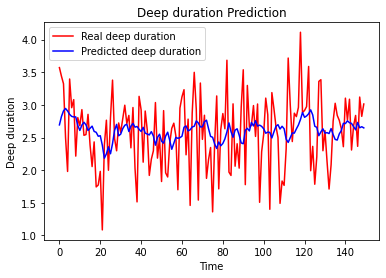

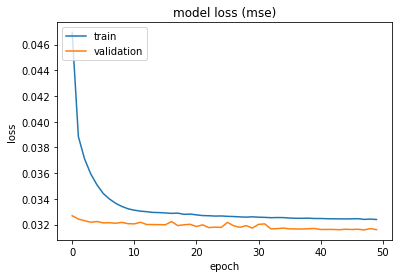

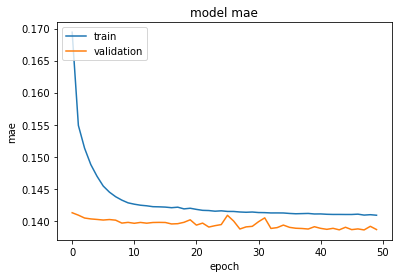

In [37]:
print("--- GRU ---\n\nTime: " + str(dict_times['gru']))
metrics(model_gru, trainX, trainY, testX, testY, dict_histories['gru'])

--- LSTM ---

Time: 224.2295265197754
**********TRAIN-SET***********
MSE: 0.032095011323690414
RMSE: 0.17915080609277317
MAE: 0.14006805419921875
**********TEST-SET***********
MSE: 0.03206949681043625
RMSE: 0.17907958233823376
MAE: 0.14014847576618195


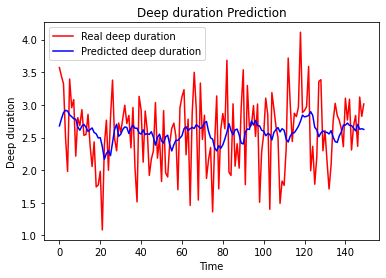

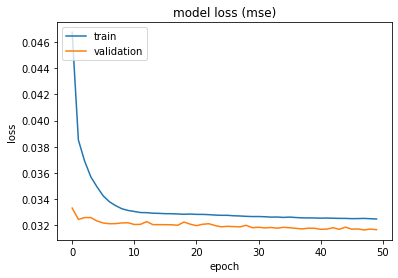

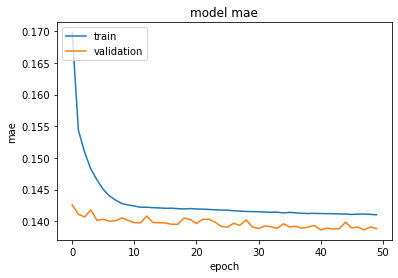

In [38]:
print("--- LSTM ---\n\nTime: " + str(dict_times['lstm']))
metrics(model_lstm, trainX, trainY, testX, testY, dict_histories['lstm'])

--- Bidirectional ---

Time: 515.7144947052002
**********TRAIN-SET***********
MSE: 0.0320727564394474
RMSE: 0.1790886831696727
MAE: 0.1399395912885666
**********TEST-SET***********
MSE: 0.03207666054368019
RMSE: 0.17909958275685678
MAE: 0.140134796500206


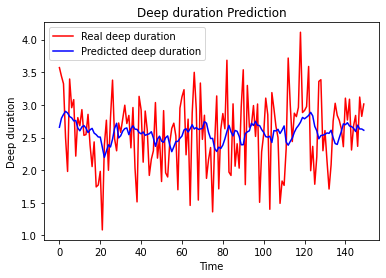

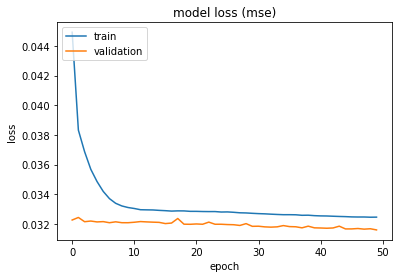

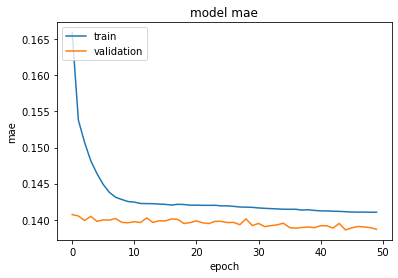

In [39]:
print("--- Bidirectional ---\n\nTime: " + str(dict_times['bidirectional']))
metrics(model_bi, trainX, trainY, testX, testY, dict_histories['bidirectional'])

--- Time2Vec - LSTM ---

Time: 124.24958610534668
**********TRAIN-SET***********
MSE: 0.03220032528042793
RMSE: 0.17944449080545197
MAE: 0.1405671238899231
**********TEST-SET***********
MSE: 0.03218967467546463
RMSE: 0.17941481175049243
MAE: 0.1406337469816208


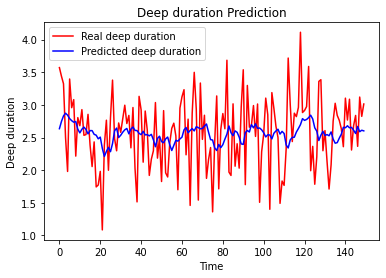

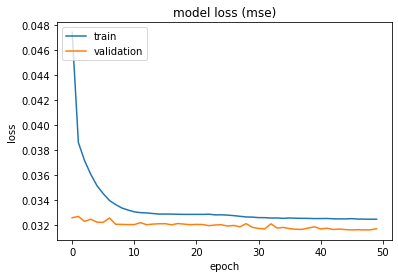

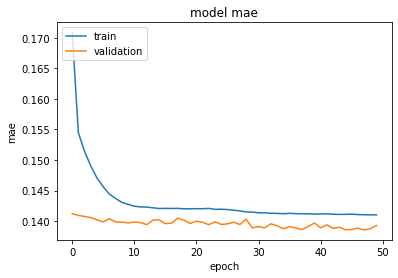

In [40]:
print("--- Time2Vec - LSTM ---\n\nTime: " + str(dict_times['time2vec']))
metrics(model_t2v, trainX, trainY, testX, testY, dict_histories['time2vec'])

--- CNN - LSTM ---

Time: 161.21596097946167
**********TRAIN-SET***********
MSE: 0.03259768337011337
RMSE: 0.18054828542557078
MAE: 0.14140097796916962
**********TEST-SET***********
MSE: 0.032791588455438614
RMSE: 0.18108447878114406
MAE: 0.1419740915298462


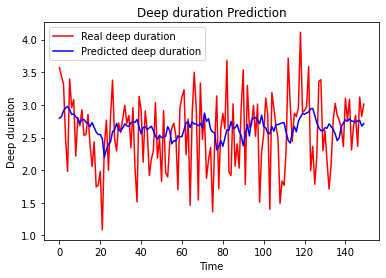

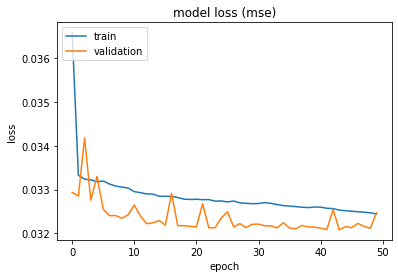

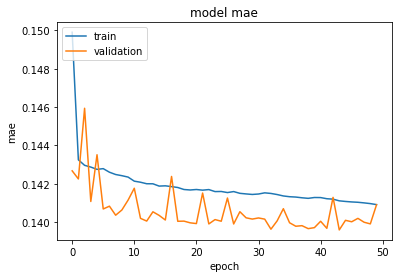

In [41]:
print("--- CNN - LSTM ---\n\nTime: " + str(dict_times['cnn']))
metrics(model_cnn, trainX, trainY, testX, testY, dict_histories['cnn'])

--- Transformer ---

Time: 604.433164358139
**********TRAIN-SET***********
MSE: 0.03247050940990448
RMSE: 0.18019575302959967
MAE: 0.1413474828004837
**********TEST-SET***********
MSE: 0.0323372446000576
RMSE: 0.1798255949526029
MAE: 0.14110593497753143


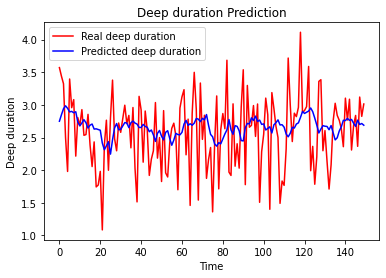

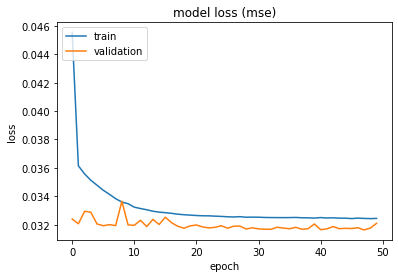

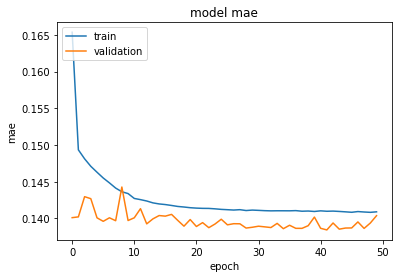

In [66]:
print("--- Transformer ---\n\nTime: " + str(time_t))
metrics(model_transformer, trainX, trainY, testX, testY, history_t.history)

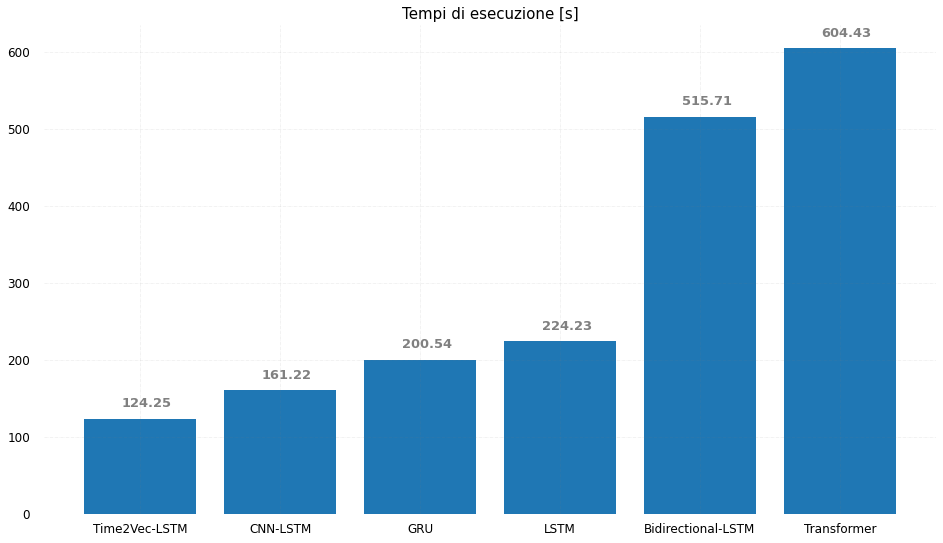

In [125]:
price = [dict_times['time2vec'], dict_times['cnn'], dict_times['gru'], dict_times['lstm'], dict_times['bidirectional'],   time_t]
name = ['Time2Vec-LSTM',  'CNN-LSTM', 'GRU', 'LSTM', 'Bidirectional-LSTM', 'Transformer']
 
# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
 
# Horizontal Bar Plot
ax.bar(name, price)
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(b = True, color ='grey', 
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 

# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_x()+0.27, i.get_height()+15,
             str(round((i.get_height()), 2)),
             fontsize = 13, fontweight ='bold',
             color ='grey')

# Add Plot Title
ax.set_title('Tempi di esecuzione [s]',
             loc ='center', fontsize = 15)
plt.rcParams.update({'font.size': 12})
# Show Plot
plt.show()